<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Deep_Learning/07_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization
- (Internal) Covariate Shift
  - Change in the distribution of network activations due to the change in network parameters during training
  - Layer가 깊어질수록 covariate shift가 심해짐

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:06<00:00, 27620314.58it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


In [4]:
class Model(nn.Module):
  def __init__(self, drop_prob):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(32*32*3, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(drop_prob)
    self.activation = nn.Sigmoid()

    self.bn1 = nn.BatchNorm1d(256)
    self.bn2 = nn.BatchNorm1d(128)

  def forward(self, x):
    z1 = self.linear1(x)
    z1 = self.bn1(z1) # activation 이전에 사용
    a1 = self.activation(z1)
    a1 = self.dropout(a1)

    z2 = self.linear2(a1)
    z2 = self.bn2(z2)
    a2 = self.activation(z2)
    a2 = self.dropout(a2)

    z3 = self.linear3(a2)

    return z3

In [15]:
model = Model(0.1).to(device).train()

In [16]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 30
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()
  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    logits = model(b_x) # forward propagation
    loss = criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters

    avg_cost += loss/total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())

Epoch : 1 / 30, cost: 1.8547362089157104
Epoch : 2 / 30, cost: 1.7423920631408691
Epoch : 3 / 30, cost: 1.6902241706848145
Epoch : 4 / 30, cost: 1.6435089111328125
Epoch : 5 / 30, cost: 1.5847588777542114
Epoch : 6 / 30, cost: 1.5356863737106323
Epoch : 7 / 30, cost: 1.4904696941375732
Epoch : 8 / 30, cost: 1.4590024948120117
Epoch : 9 / 30, cost: 1.4265364408493042
Epoch : 10 / 30, cost: 1.396658182144165
Epoch : 11 / 30, cost: 1.3713356256484985
Epoch : 12 / 30, cost: 1.3447872400283813
Epoch : 13 / 30, cost: 1.3244763612747192
Epoch : 14 / 30, cost: 1.303996205329895
Epoch : 15 / 30, cost: 1.2863011360168457
Epoch : 16 / 30, cost: 1.2628982067108154
Epoch : 17 / 30, cost: 1.2480438947677612
Epoch : 18 / 30, cost: 1.2319601774215698
Epoch : 19 / 30, cost: 1.2103482484817505
Epoch : 20 / 30, cost: 1.2001794576644897
Epoch : 21 / 30, cost: 1.1810221672058105
Epoch : 22 / 30, cost: 1.1680324077606201
Epoch : 23 / 30, cost: 1.1496630907058716
Epoch : 24 / 30, cost: 1.1327874660491943
Epo

In [19]:
train_avg_costs = [a.cpu() for a in train_avg_costs]
test_avg_costs = [a.cpu() for a in test_avg_costs]

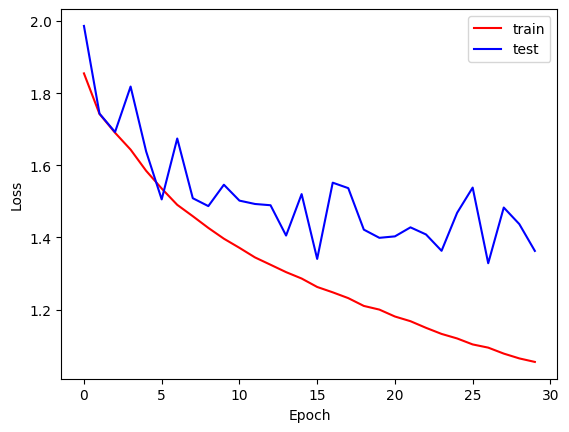

In [20]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [21]:
# Test set accuracy
from sklearn.metrics import accuracy_score

correct = 0
total = 0

model.eval()
for b_x, b_y in test_dataloader:
  b_x = b_x.view(-1, 32*32*3).to(device)
  
  with torch.no_grad():
    logits = model(b_x)
  probs = nn.Softmax(dim=1)(logits)
  
  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()
  # -> accuracy_score(b_y, logits)랑 같은지 확인
  # total == len(test_dataloader) 맞는지 확인

print(f'Accuracy of the network on test images: {100 * correct / total} %')

Accuracy of the network on test images: 52.59 %
